# **Part 4 - Ajust d'hiperparàmetres amb Grid Search**

En aquest *Notebook* veurem com utilitzar Grid Search per buscar els hiperparàmetres òptims per al nostre model. Hem intentat utilitzar la funció ``GridSearchCV`` de la llibreria ``sklearn``; no obstant, no ha estat possible fer-la funcionar correctament de forma conjunta amb la llibreria ``fastai``. Per tant, s'ha optat per implementar la nostra pròpia versió -segurament no tant òptima- del Grid Search.

### **0. Llibreries**

Comencem carregant les llibreries necessàries. Comencem per ``fastai`` i tots els seus sub-mòduls que hem estat utilitzant en els altres exemples:

In [1]:
import fastai
from fastai.vision.all import *
from fastai.callback.fp16 import *

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<br>

Durant les proves i experiments fets abans de redactar aquest *Notebook*, hem vist que ``fastai`` per defecte no buida la memòria de la CUDA quan acaba un entrenament d'una xarxa o quan se sobrescriu un dataloader vell. Això no seria gaire problema si només treballessim amb una o dues xarxes en el Notebook; no obstant, com que volem fer GridSearch, estarem creant contínuament noves xarxes per provar hiperparàmetres, i la memòria CUDA s'emplenarà molt ràpid.

Per solventar aquest problema, carreguem ``pytorch`` (per poder fer servir el mètode ``torch.cuda.empty_cache()``) i ``gc`` (per poder fer servir ``gc.collect()``).

In [2]:
import gc
import torch

<br>

### **1. Crear el DataLoader**

Creem el DataLoader. Per a aquest exemple suposarem que el Dataset es troba descomprimit a la mateixa carpeta des d'on estem executant aquest Notebook, i sense que la seva estructura de fitxers hagi sofert cap canvi:

In [3]:
dls = ImageDataLoaders.from_folder(
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), # Usem CUDA si està disponible
    path = 'dataset_CIFAR10', # Path al dataset
    train = 'train', # Sub-directori amb les imatges d'entrenament
    valid = 'validation', # Sub-directori amb les imatges de validació
    seed = 42, # Llavor aleatòria
    batch_tfms=aug_transforms(size=224, min_scale=0.75), # Apliquem transformacions
    bs = 64) # Mida del batch

Com sempre, mostrem un *batch* d'imatges per comprovar que s'hagi construit bé el DataLoader:

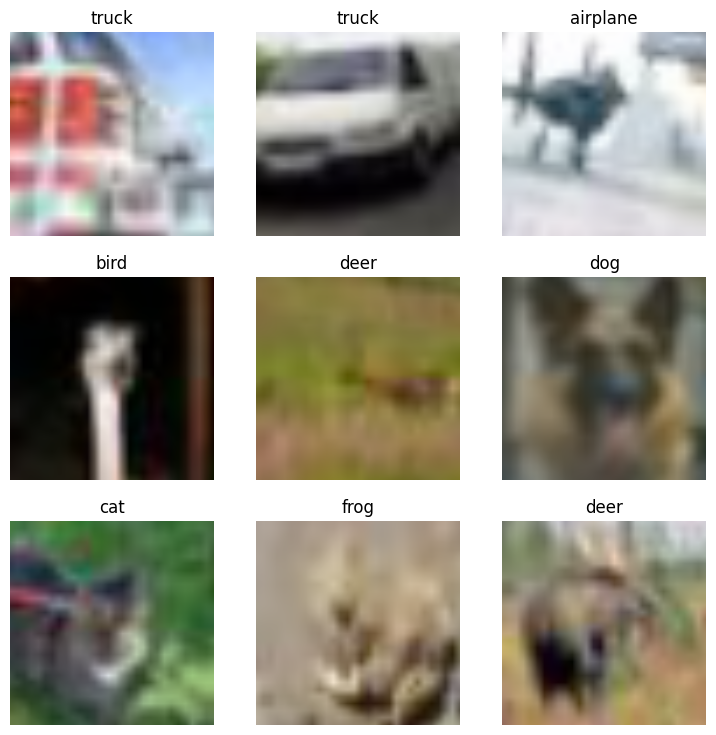

In [4]:
dls.show_batch()

<br>

### **2. Grid Search**

Anem ara a fer el nostre algorisme *casolà* de Grid Search. Comencem definint els hiperparàmetres que volem considerar:

In [5]:
# Learning rates base:
lr_candidates = [1e-3, 1e-4, 1e-5]

# Optimitzadors: provarem descens al gradient estocàstic i dues variants d'Adam:
optim_candidates = [RAdam, SGD, Adam]

# Funcions de loss:
loss_candidates = [nn.CrossEntropyLoss(), nn.NLLLoss()]

Quantes búsquedes caldrà fer?

In [6]:
total_tries = len(lr_candidates) * len(optim_candidates) * len(loss_candidates)

print("Haurem de fer", total_tries, "búsquedes.")

Haurem de fer 18 búsquedes.


<br>

La següent cel·la de codi realitzarà una búsqueda dels millors hiperparàmetres entre els que hem considerat. Noti's que, depenent del nostre ordinador, **aquesta cel·la pot tardar un temps considerable en executar-se**.

In [9]:
# Variables per emmagatzamar la precisió del millor model
# i els seus hiperparàmetres:
best_accuracy = 0.0
best_params = []

# Búsqueda actual:
current_try = 0

# Recorrem tots els hiperparàmetres mitjançant bucles 'for' aniuats:
for lr in lr_candidates:
    for o in optim_candidates:
        for l in loss_candidates:
            
            # Buidem cache de la CUDA, o si no la nostra búsqueda s'acabarà aviat
            torch.cuda.empty_cache()
            gc.collect()
        
            # Construïm un learner amb els hiperparàmetres que hem triat:
            learner = vision_learner(dls, resnet18, loss_func = l,  metrics = accuracy, opt_func = o, lr = lr).to_fp16()
            # Noti's que com a arquitectura hem fet servir una resnet18 per no allargar excessivament el Notebook,
            # donat que la búsqueda d'hiperparàmetres usant Grid Search es un procés costós


            with learner.no_bar(), learner.no_logging():  # Desactivem les barres de progrés

                # Avancem el contador:
                current_try += 1

                # Entrenem la xarxa durant 6 èpoques, congelant 2, i guardem la precisió final:
                learner.fine_tune(6, freeze_epochs = 2)
                current_accuracy = learner.validate()[1]

                # Mostrem els resultats d'aquesta búsqueda:
                print("Done test", current_try, "/", total_tries)
                print("\tAccuracy =", current_accuracy)
                print("\tParams. = ", [lr, o, l])
                print("\n")

                # Si la precisió obtinguda és millor que la que teníem fins ara,
                # guardem els hiperparàmetres actuals:
                if current_accuracy > best_accuracy:
                    best_params = [lr, o, l]
                    best_accuracy = current_accuracy

            # Buidem cache de la CUDA de nou
            torch.cuda.empty_cache()
            gc.collect()
                
# Mostrem el resultat final:
print("Best accuracy: ", best_accuracy)
print("Best params: ", best_params)

Done test 1 / 18
	Accuracy = 0.8952999711036682
	Params. =  [0.001, <function RAdam at 0x7fa4ce8f9b80>, CrossEntropyLoss()]


Done test 2 / 18
	Accuracy = 0.7616999745368958
	Params. =  [0.001, <function RAdam at 0x7fa4ce8f9b80>, NLLLoss()]


Done test 3 / 18
	Accuracy = 0.5871000289916992
	Params. =  [0.001, <function SGD at 0x7fa4ce8f9700>, CrossEntropyLoss()]


Done test 4 / 18
	Accuracy = 0.46399998664855957
	Params. =  [0.001, <function SGD at 0x7fa4ce8f9700>, NLLLoss()]


Done test 5 / 18
	Accuracy = 0.8960999846458435
	Params. =  [0.001, <function Adam at 0x7fa4ce8f9a60>, CrossEntropyLoss()]


Done test 6 / 18
	Accuracy = 0.7918000221252441
	Params. =  [0.001, <function Adam at 0x7fa4ce8f9a60>, NLLLoss()]


Done test 7 / 18
	Accuracy = 0.899399995803833
	Params. =  [0.0001, <function RAdam at 0x7fa4ce8f9b80>, CrossEntropyLoss()]


Done test 8 / 18
	Accuracy = 0.7864999771118164
	Params. =  [0.0001, <function RAdam at 0x7fa4ce8f9b80>, NLLLoss()]


Done test 9 / 18
	Accuracy = 0.5

Observem que la millor combinació d'hiperparàmetres és:

* Learning rate : 1e-5
* Funció de loss : Cross Entropy
* Optimitzador: RAdam

El que hauríem de fer ara, coneguda aquesta informació, seria crear un nou learner amb aquests hiperparàmetres i entrenar-lo durant més èpoques.